# 🧊 Peru Minimum Temperature (Tmin) Raster Analysis

This notebook performs comprehensive analysis of Peru's minimum temperature data including:
- Zonal statistics extraction by administrative units
- Climate risk analysis (frost/cold surges)
- Visualization of temperature patterns
- Data preparation for Streamlit app

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import rioxarray as rxr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up paths using absolute paths
base_path = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
data_path = base_path / 'data'
raster_path = base_path / 'tmin_raster.tif'

# Ensure we have the correct absolute paths
base_path = base_path.resolve()
data_path = data_path.resolve()
raster_path = raster_path.resolve()

print(f"Base path: {base_path}")
print(f"Data path: {data_path}")
print(f"Raster path: {raster_path}")
print(f"Raster exists: {raster_path.exists()}")

Base path: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster
Data path: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster/data
Raster path: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster/tmin_raster.tif
Raster exists: True


## 1. Load and Explore the Raster Data

In [12]:
# Load raster with rasterio
with rasterio.open(raster_path) as src:
    raster_data = src.read()
    raster_meta = src.meta
    raster_crs = src.crs
    raster_bounds = src.bounds
    raster_transform = src.transform

print(f"Raster shape: {raster_data.shape}")
print(f"Raster CRS: {raster_crs}")
print(f"Raster bounds: {raster_bounds}")
print(f"Number of bands: {raster_data.shape[0]}")
print(f"Data type: {raster_data.dtype}")
print(f"No data value: {raster_meta.get('nodata')}")

# Basic statistics
for band in range(raster_data.shape[0]):
    band_data = raster_data[band]
    valid_data = band_data[band_data != raster_meta.get('nodata', np.nan)]
    print(f"\nBand {band + 1} statistics:")
    print(f"  Min: {np.nanmin(valid_data):.2f}")
    print(f"  Max: {np.nanmax(valid_data):.2f}")
    print(f"  Mean: {np.nanmean(valid_data):.2f}")
    print(f"  Valid pixels: {len(valid_data)}")

Raster shape: (5, 397, 285)
Raster CRS: GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]
Raster bounds: BoundingBox(left=-81.38, bottom=-18.65000000000002, right=-67.1300000000008, top=1.2000000000000002)
Number of bands: 5
Data type: float32
No data value: None

Band 1 statistics:
  Min: -9.05
  Max: 24.64
  Mean: 18.01
  Valid pixels: 113145

Band 2 statistics:
  Min: -10.02
  Max: 24.39
  Mean: 17.91
  Valid pixels: 113145

Band 3 statistics:
  Min: -9.87
  Max: 24.21
  Mean: 17.77
  Valid pixels: 113145

Band 4 statistics:
  Min: -9.06
  Max: 24.12
  Mean: 17.61
  Valid pixels: 113145

Band 5 statistics:
  Min: -8.85
  Max: 24.15
  Mean: 17.82
  Valid pixels: 113145


ERROR 1: PROJ: internal_proj_identify: /Users/gabrielsaco/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


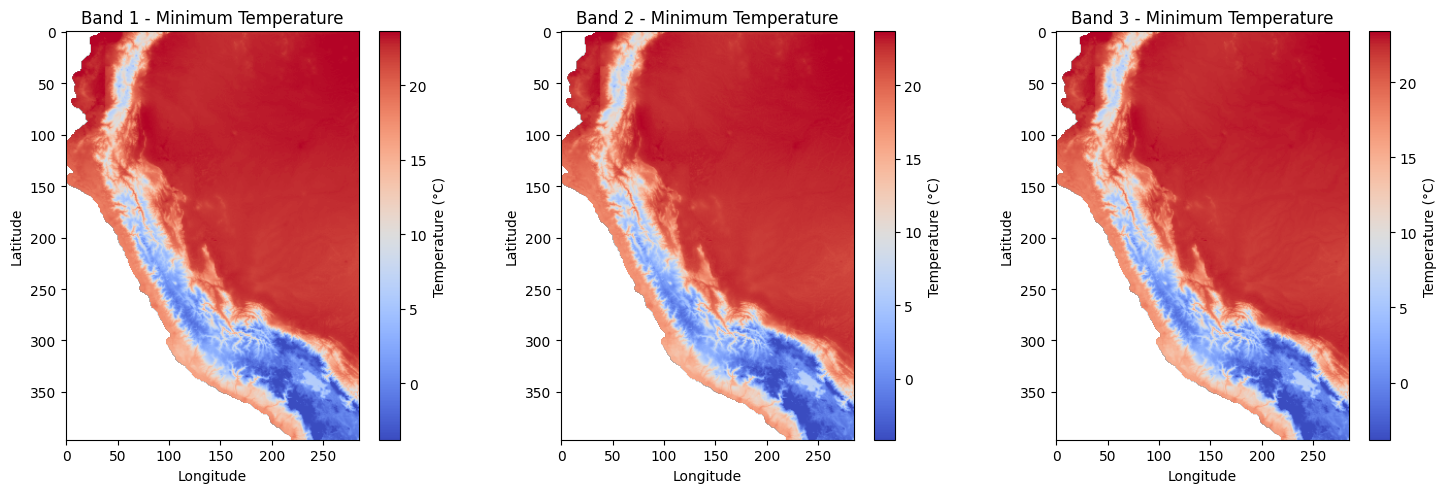

In [13]:
# Visualize the raster
fig, axes = plt.subplots(1, min(3, raster_data.shape[0]), figsize=(15, 5))
if raster_data.shape[0] == 1:
    axes = [axes]

for i, ax in enumerate(axes[:raster_data.shape[0]]):
    band_data = raster_data[i]
    im = ax.imshow(band_data, cmap='coolwarm', vmin=np.nanpercentile(band_data, 1), 
                   vmax=np.nanpercentile(band_data, 99))
    ax.set_title(f'Band {i+1} - Minimum Temperature')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(im, ax=ax, label='Temperature (°C)')

plt.tight_layout()
plt.show()

## 2. Download and Load Administrative Boundaries

In [14]:
# Try to download boundaries with improved error handling
import sys
sys.path.append(str(data_path))

print("Attempting to download Peru administrative boundaries...")

try:
    from download_boundaries import download_peru_boundaries
    download_peru_boundaries()
    print("✅ Boundary download completed successfully!")
except Exception as e:
    print(f"⚠️ Error downloading boundaries: {e}")
    print("Attempting alternative approach...")
    
    # Alternative: Try to download directly using GADM data
    try:
        import requests
        import zipfile
        
        print("Trying GADM Peru data...")
        gadm_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg/gadm41_PER.gpkg"
        gadm_file = data_path / "gadm41_PER.gpkg"
        
        if not gadm_file.exists():
            print("Downloading GADM Peru data...")
            response = requests.get(gadm_url, stream=True)
            response.raise_for_status()
            
            with open(gadm_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print("✅ GADM data downloaded successfully!")
        
        # Create boundary files from GADM
        if gadm_file.exists():
            import geopandas as gpd
            
            # Load departments (level 1)
            try:
                departments = gpd.read_file(gadm_file, layer='ADM_ADM_1')
                departments['NAME_CLEAN'] = departments['NAME_1'].str.upper()
                departments.to_file(data_path / "peru_departments.geojson", driver="GeoJSON")
                print("✅ Created peru_departments.geojson")
            except:
                pass
            
            # Load districts (level 2)  
            try:
                districts = gpd.read_file(gadm_file, layer='ADM_ADM_2')
                districts['NAME_CLEAN'] = districts['NAME_2'].str.upper()
                districts['DEPT_CLEAN'] = districts['NAME_1'].str.upper()
                districts.to_file(data_path / "peru_districts.geojson", driver="GeoJSON")
                print("✅ Created peru_districts.geojson")
            except:
                pass
    
    except Exception as alt_e:
        print(f"⚠️ Alternative download also failed: {alt_e}")
        print("📌 You may need to manually download Peru boundary data")
        print("   or the analysis will continue with available data.")

print("\n" + "="*50)

Attempting to download Peru administrative boundaries...
⚠️ Error downloading boundaries: 406 Client Error: Not Acceptable for url: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip
Attempting alternative approach...
Trying GADM Peru data...
⚠️ Error downloading boundaries: 406 Client Error: Not Acceptable for url: https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_1_states_provinces.zip
Attempting alternative approach...
Trying GADM Peru data...
✅ Created peru_departments.geojson
✅ Created peru_districts.geojson

✅ Created peru_departments.geojson
✅ Created peru_districts.geojson



In [15]:
# Load administrative boundaries
boundaries_files = {
    'departments': data_path / 'peru_departments.geojson',
    'districts': data_path / 'peru_districts.geojson'
}

boundaries = {}
for level, file_path in boundaries_files.items():
    if file_path.exists():
        gdf = gpd.read_file(file_path)
        # Ensure CRS is EPSG:4326
        if gdf.crs != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')
        boundaries[level] = gdf
        print(f"Loaded {level}: {len(gdf)} features")
        print(f"  Columns: {gdf.columns.tolist()}")

# Use the most detailed level available
if 'districts' in boundaries:
    admin_gdf = boundaries['districts'].copy()
    admin_level = 'districts'
else:
    admin_gdf = boundaries['departments'].copy()
    admin_level = 'departments'

print(f"\nUsing {admin_level} for analysis: {len(admin_gdf)} features")

Loaded departments: 26 features
  Columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'NAME_CLEAN', 'geometry']
Loaded districts: 195 features
  Columns: ['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'NAME_CLEAN', 'DEPT_CLEAN', 'geometry']

Using districts for analysis: 195 features
Loaded districts: 195 features
  Columns: ['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'NAME_CLEAN', 'DEPT_CLEAN', 'geometry']

Using districts for analysis: 195 features


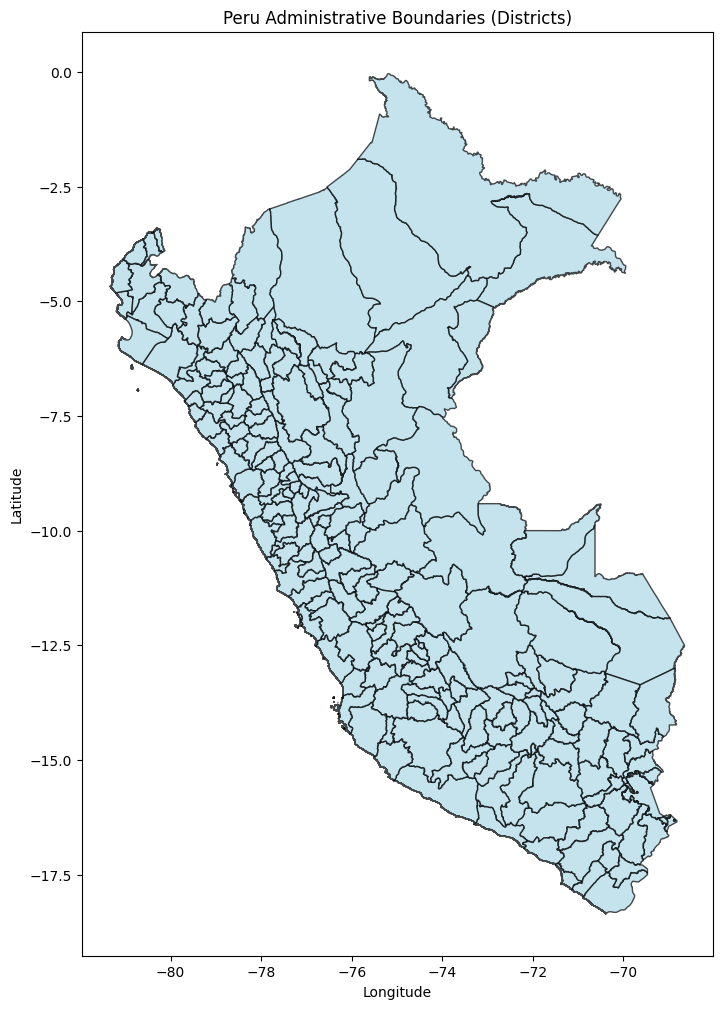

In [16]:
# Visualize boundaries
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
admin_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black', alpha=0.7)
ax.set_title(f'Peru Administrative Boundaries ({admin_level.title()})')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## 3. Zonal Statistics Calculation

In [17]:
def calculate_zonal_stats(raster_path, geometries, band=1):
    """
    Calculate comprehensive zonal statistics.
    Returns statistics for each geometry.
    """
    stats_list = []
    
    # Define statistics to calculate
    stats_funcs = [
        'count', 'min', 'max', 'mean', 'std',
        'percentile_10', 'percentile_90', 'percentile_25', 'percentile_75'
    ]
    
    print(f"Calculating zonal statistics for band {band}...")
    
    # Calculate zonal stats
    zonal_results = zonal_stats(
        geometries,
        str(raster_path),
        band=band,
        stats=stats_funcs,
        nodata=raster_meta.get('nodata')
    )
    
    # Convert to DataFrame
    stats_df = pd.DataFrame(zonal_results)
    
    # Add custom metrics
    stats_df['range'] = stats_df['max'] - stats_df['min']  # Temperature range
    stats_df['frost_risk'] = (stats_df['min'] < 0).astype(int)  # Binary frost risk
    stats_df['extreme_cold'] = (stats_df['percentile_10'] < -5).astype(int)  # Extreme cold risk
    
    return stats_df

# Calculate zonal statistics for the first band
zonal_stats_df = calculate_zonal_stats(raster_path, admin_gdf.geometry, band=1)

# Combine with administrative data
admin_stats = admin_gdf.copy()
admin_stats = pd.concat([admin_stats.reset_index(drop=True), zonal_stats_df.reset_index(drop=True)], axis=1)

print(f"Zonal statistics calculated for {len(admin_stats)} administrative units")
print(f"Statistics columns: {zonal_stats_df.columns.tolist()}")
print("\nFirst few rows:")
admin_stats[['NAME_CLEAN', 'mean', 'min', 'max', 'std', 'frost_risk']].head()

Calculating zonal statistics for band 1...
Zonal statistics calculated for 195 administrative units
Statistics columns: ['min', 'max', 'mean', 'count', 'std', 'percentile_10', 'percentile_90', 'percentile_25', 'percentile_75', 'range', 'frost_risk', 'extreme_cold']

First few rows:


,NAME_CLEAN,mean,min,max,std,frost_risk
0,BAGUA,19.336638,10.901891,22.087481,1.956727,0
1,BONGARÁ,14.670324,9.859994,20.776640,2.431620,0
2,CHACHAPOYAS,10.717833,5.607545,19.025255,2.744575,0
3,CONDORCANQUI,21.287401,15.681557,23.357122,1.670605,0
4,LUYA,12.784175,7.517243,19.174940,3.062711,0


In [18]:
# Check for units and rescale if necessary
# If temperatures seem to be scaled (e.g., °C * 10), rescale them
temp_cols = ['min', 'max', 'mean', 'std', 'percentile_10', 'percentile_90', 'percentile_25', 'percentile_75', 'range']

print("Temperature statistics summary:")
print(admin_stats[temp_cols].describe())

# Check if values seem to be scaled (typical range for Peru should be around -10 to 30°C)
mean_temp_range = admin_stats['mean'].max() - admin_stats['mean'].min()
if mean_temp_range > 100:  # Likely scaled by 10 or 100
    print("\nTemperature values appear to be scaled. Rescaling...")
    scale_factor = 10 if mean_temp_range < 1000 else 100
    for col in temp_cols:
        admin_stats[col] = admin_stats[col] / scale_factor
    
    # Recalculate frost risk with corrected values
    admin_stats['frost_risk'] = (admin_stats['min'] < 0).astype(int)
    admin_stats['extreme_cold'] = (admin_stats['percentile_10'] < -5).astype(int)
    
    print(f"Rescaled by factor of {scale_factor}")
    print("Updated temperature statistics:")
    print(admin_stats[temp_cols].describe())

Temperature statistics summary:
              min         max        mean         std  percentile_10  \
count  195.000000  195.000000  195.000000  195.000000     195.000000   
mean     4.796728   15.877700   10.342383    2.775447       6.893931   
std      7.508646    5.595401    7.127984    1.688823       7.876355   
min     -8.782926    1.679664   -3.602801    0.114607      -6.532102   
25%     -0.327461   12.252294    4.391262    1.530927       1.127583   
50%      3.264765   16.972292    9.119789    2.606773       4.624023   
75%      8.901165   20.135845   16.347695    3.618994      12.437754   
max     22.663803   23.911810   23.008956    9.519990      22.819490   

       percentile_90  percentile_25  percentile_75       range  
count     195.000000     195.000000     195.000000  195.000000  
mean       13.883977       8.321085      12.370600   11.080972  
std         6.504037       7.902404       7.029688    5.525823  
min         0.113911      -6.019096      -2.478335    0.605

## 4. Analysis and Visualizations

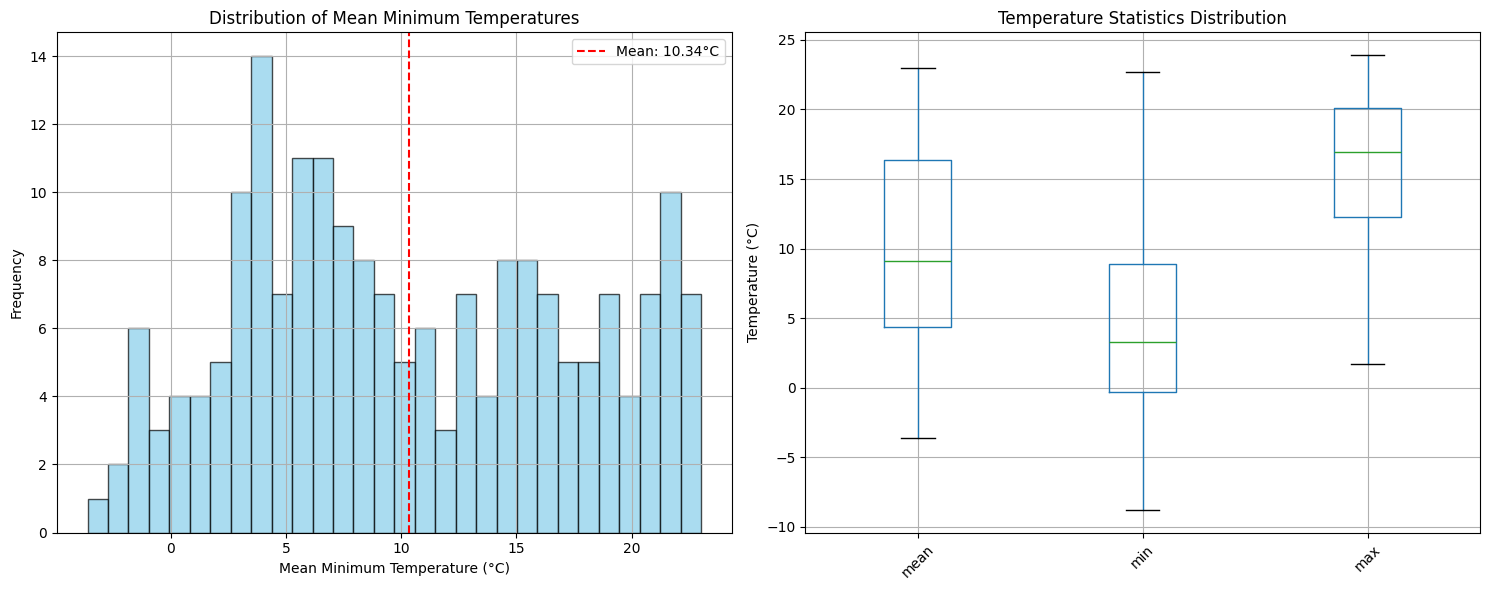

In [19]:
# 1. Distribution of mean minimum temperatures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram
admin_stats['mean'].hist(bins=30, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Mean Minimum Temperature (°C)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Mean Minimum Temperatures')
ax1.axvline(admin_stats['mean'].mean(), color='red', linestyle='--', label=f'Mean: {admin_stats["mean"].mean():.2f}°C')
ax1.legend()

# Box plot
admin_stats.boxplot(column=['mean', 'min', 'max'], ax=ax2)
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Temperature Statistics Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

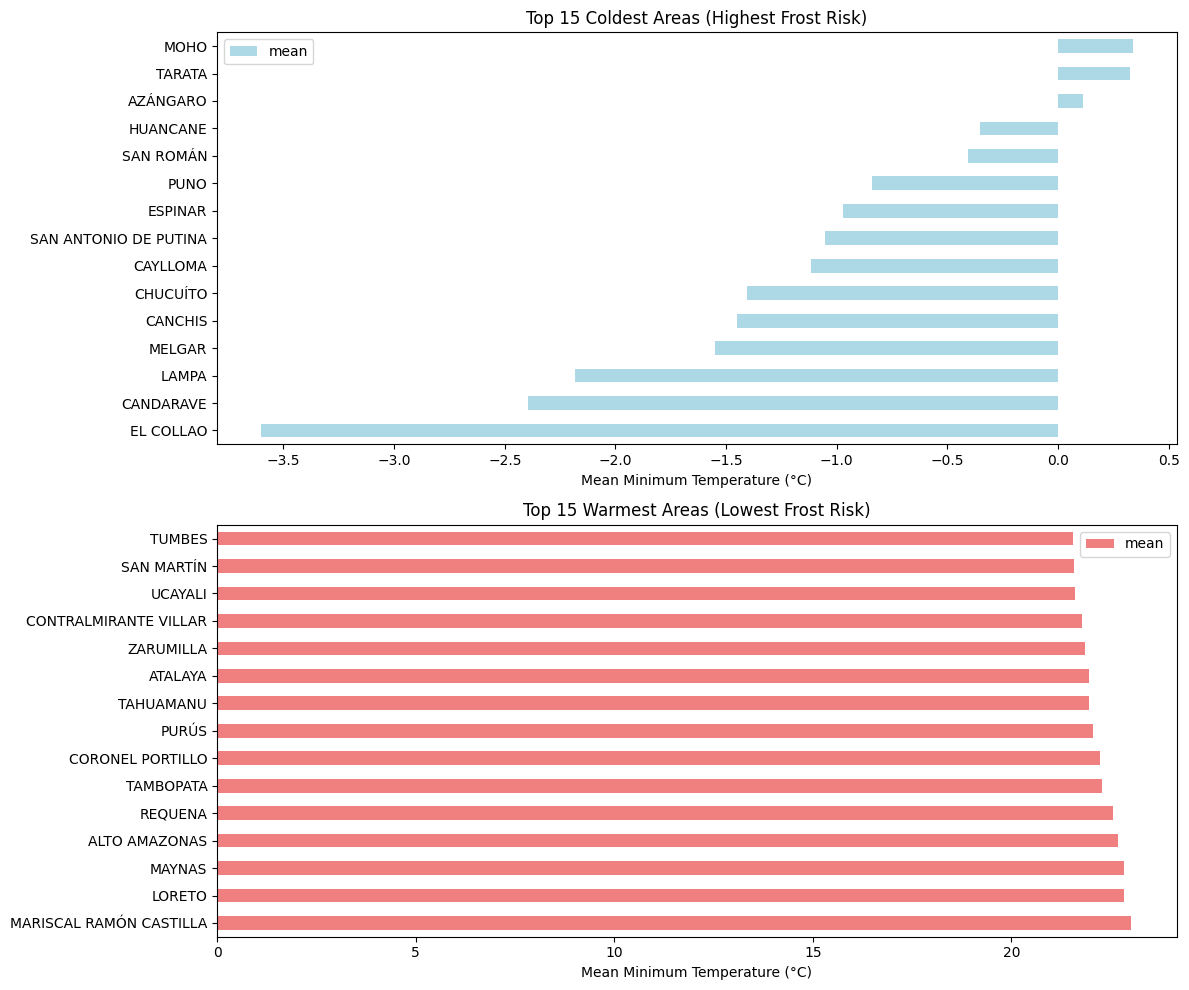

COLDEST AREAS (Highest Climate Risk):
                NAME_CLEAN      mean       min  frost_risk
163              EL COLLAO -3.602801 -8.722504           1
184              CANDARAVE -2.396791 -8.273415           1
166                  LAMPA -2.180770 -4.938025           1
167                 MELGAR -1.551617 -4.832971           1
71                 CANCHIS -1.451477 -6.198120           1
162               CHUCUÍTO -1.406835 -5.608086           1
38                CAYLLOMA -1.118497 -5.922765           1
170  SAN ANTONIO DE PUTINA -1.055126 -5.046488           1
74                 ESPINAR -0.973006 -4.944066           1
169                   PUNO -0.843151 -5.336930           1
171              SAN ROMÁN -0.409164 -3.155852           1
164               HUANCANE -0.353346 -3.264121           1
160               AZÁNGARO  0.110210 -3.425058           1
187                 TARATA  0.323519 -8.782926           1
168                   MOHO  0.338379 -2.456863           1

WARMEST AREAS (Lo

In [20]:
# 2. Ranking - Coldest and Warmest areas
n_top = min(15, len(admin_stats))

# Sort by mean temperature
coldest = admin_stats.nsmallest(n_top, 'mean')
warmest = admin_stats.nlargest(n_top, 'mean')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Coldest areas (highest frost risk)
coldest_plot = coldest.plot(x='NAME_CLEAN', y='mean', kind='barh', ax=ax1, color='lightblue')
ax1.set_title(f'Top {n_top} Coldest Areas (Highest Frost Risk)')
ax1.set_xlabel('Mean Minimum Temperature (°C)')
ax1.set_ylabel('')

# Warmest areas (lowest frost risk)
warmest_plot = warmest.plot(x='NAME_CLEAN', y='mean', kind='barh', ax=ax2, color='lightcoral')
ax2.set_title(f'Top {n_top} Warmest Areas (Lowest Frost Risk)')
ax2.set_xlabel('Mean Minimum Temperature (°C)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("COLDEST AREAS (Highest Climate Risk):")
print(coldest[['NAME_CLEAN', 'mean', 'min', 'frost_risk']].to_string())
print("\nWARMEST AREAS (Lowest Climate Risk):")
print(warmest[['NAME_CLEAN', 'mean', 'min', 'frost_risk']].to_string())

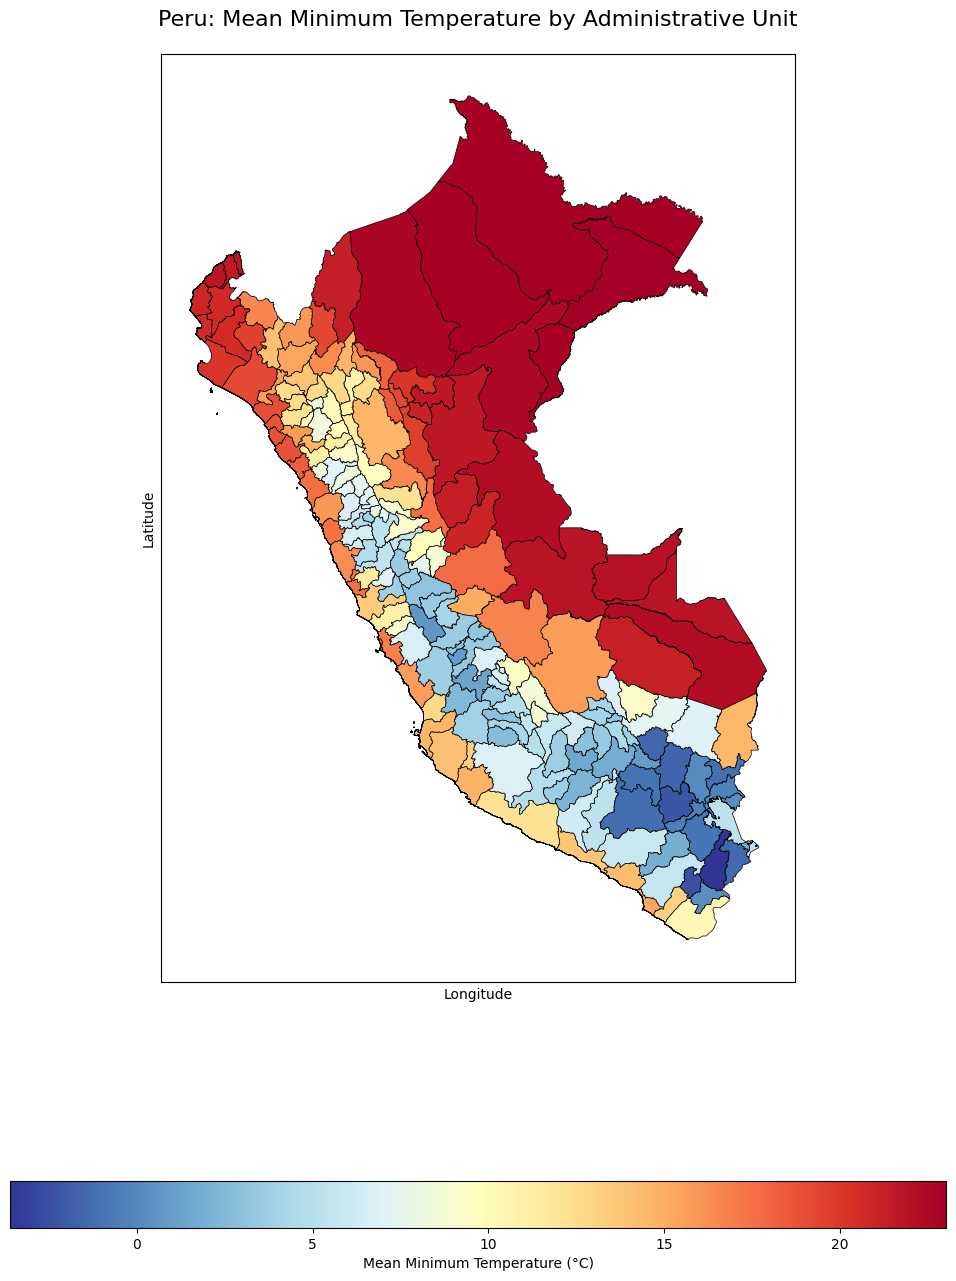

In [21]:
# 3. Static Choropleth Map
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Create choropleth map
admin_stats.plot(
    column='mean',
    cmap='RdYlBu_r',
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Mean Minimum Temperature (°C)',
                'orientation': 'horizontal',
                'shrink': 0.8}
)

ax.set_title('Peru: Mean Minimum Temperature by Administrative Unit', fontsize=16, pad=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Remove axes ticks for cleaner look
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig(data_path / 'peru_tmin_map.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Climate Risk Analysis

CLIMATE RISK ANALYSIS SUMMARY:
           NAME_CLEAN   mean                min       frost_risk extreme_cold
                count   mean   min    max  mean   min        sum          sum
risk_level                                                                   
High               12  -1.45 -3.60  -0.35 -5.52 -8.72         12            2
Low               140  13.59  5.25  23.01  7.41 -6.80         14            1
Medium             43   3.06  0.11   4.95 -0.83 -8.78         27            1


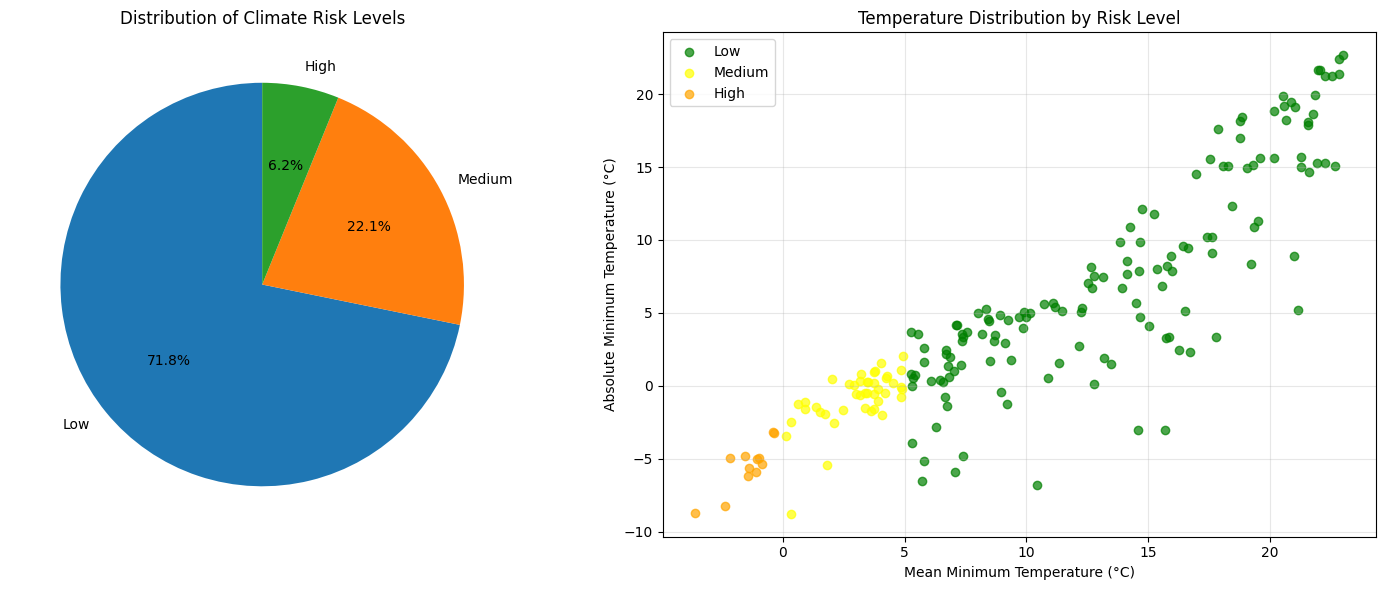

In [22]:
# Climate risk classification
admin_stats['risk_level'] = 'Low'
admin_stats.loc[admin_stats['mean'] < 5, 'risk_level'] = 'Medium'
admin_stats.loc[admin_stats['mean'] < 0, 'risk_level'] = 'High'
admin_stats.loc[admin_stats['min'] < -10, 'risk_level'] = 'Very High'

# Summary statistics by risk level
risk_summary = admin_stats.groupby('risk_level').agg({
    'NAME_CLEAN': 'count',
    'mean': ['mean', 'min', 'max'],
    'min': ['mean', 'min'],
    'frost_risk': 'sum',
    'extreme_cold': 'sum'
}).round(2)

print("CLIMATE RISK ANALYSIS SUMMARY:")
print(risk_summary)

# Visualize risk distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Risk level distribution
risk_counts = admin_stats['risk_level'].value_counts()
risk_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of Climate Risk Levels')
ax1.set_ylabel('')

# Temperature vs Risk
risk_colors = {'Low': 'green', 'Medium': 'yellow', 'High': 'orange', 'Very High': 'red'}
for risk in admin_stats['risk_level'].unique():
    data = admin_stats[admin_stats['risk_level'] == risk]
    ax2.scatter(data['mean'], data['min'], label=risk, alpha=0.7, color=risk_colors.get(risk, 'blue'))

ax2.set_xlabel('Mean Minimum Temperature (°C)')
ax2.set_ylabel('Absolute Minimum Temperature (°C)')
ax2.set_title('Temperature Distribution by Risk Level')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Save Results for Streamlit App

In [23]:
# Save processed data for Streamlit app
output_data = admin_stats.copy()

# Select relevant columns for the app
app_columns = [
    'NAME_CLEAN', 'geometry', 
    'count', 'min', 'max', 'mean', 'std',
    'percentile_10', 'percentile_90', 'percentile_25', 'percentile_75',
    'range', 'frost_risk', 'extreme_cold', 'risk_level'
]

# Add department/region info if available
if 'DEPT_CLEAN' in output_data.columns:
    app_columns.insert(1, 'DEPT_CLEAN')
elif any(col for col in output_data.columns if 'admin' in col.lower() or 'region' in col.lower()):
    region_col = [col for col in output_data.columns if 'admin' in col.lower() or 'region' in col.lower()][0]
    app_columns.insert(1, region_col)

# Filter columns that exist
existing_columns = [col for col in app_columns if col in output_data.columns]
output_data = output_data[existing_columns]

# Save as GeoJSON for Streamlit
output_data.to_file(data_path / 'peru_tmin_analysis.geojson', driver='GeoJSON')

# Save as CSV (without geometry) for easy download
csv_data = output_data.drop(columns=['geometry']).copy()
csv_data.to_csv(data_path / 'peru_tmin_analysis.csv', index=False)

print(f"Saved analysis results:")
print(f"  - GeoJSON: {data_path / 'peru_tmin_analysis.geojson'}")
print(f"  - CSV: {data_path / 'peru_tmin_analysis.csv'}")
print(f"  - Map: {data_path / 'peru_tmin_map.png'}")
print(f"\nData shape: {output_data.shape}")
print(f"Columns: {output_data.columns.tolist()}")

Saved analysis results:
  - GeoJSON: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster/data/peru_tmin_analysis.geojson
  - CSV: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster/data/peru_tmin_analysis.csv
  - Map: /Users/gabrielsaco/Documents/GitHub/Minimum-Temperature-Raster/data/peru_tmin_map.png

Data shape: (195, 16)
Columns: ['NAME_CLEAN', 'DEPT_CLEAN', 'geometry', 'count', 'min', 'max', 'mean', 'std', 'percentile_10', 'percentile_90', 'percentile_25', 'percentile_75', 'range', 'frost_risk', 'extreme_cold', 'risk_level']


## 7. Summary Statistics and Key Findings

In [24]:
print("="*60)
print("PERU MINIMUM TEMPERATURE ANALYSIS - KEY FINDINGS")
print("="*60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"  • Administrative units analyzed: {len(admin_stats)}")
print(f"  • Administrative level: {admin_level}")
print(f"  • Raster bands processed: {raster_data.shape[0]}")

print(f"\n🌡️ TEMPERATURE STATISTICS:")
print(f"  • Overall mean minimum temperature: {admin_stats['mean'].mean():.2f}°C")
print(f"  • Coldest area mean: {admin_stats['mean'].min():.2f}°C")
print(f"  • Warmest area mean: {admin_stats['mean'].max():.2f}°C")
print(f"  • Temperature range: {admin_stats['mean'].max() - admin_stats['mean'].min():.2f}°C")

print(f"\n❄️ FROST RISK ANALYSIS:")
print(f"  • Areas with frost risk (min < 0°C): {admin_stats['frost_risk'].sum()} ({admin_stats['frost_risk'].mean()*100:.1f}%)")
print(f"  • Areas with extreme cold risk (p10 < -5°C): {admin_stats['extreme_cold'].sum()} ({admin_stats['extreme_cold'].mean()*100:.1f}%)")

print(f"\n🎯 HIGH-RISK AREAS (Top 5 coldest):")
high_risk = admin_stats.nsmallest(5, 'mean')
for idx, row in high_risk.iterrows():
    print(f"  • {row['NAME_CLEAN']}: {row['mean']:.2f}°C (min: {row['min']:.2f}°C)")

print(f"\n🔥 PRIORITY REGIONS FOR POLICY INTERVENTION:")
priority_areas = admin_stats[admin_stats['risk_level'].isin(['High', 'Very High'])]
print(f"  • {len(priority_areas)} areas require immediate attention")
print(f"  • Focus regions: High-Andean areas and Amazon cold surge zones")

print("\n" + "="*60)

PERU MINIMUM TEMPERATURE ANALYSIS - KEY FINDINGS

📊 DATASET OVERVIEW:
  • Administrative units analyzed: 195
  • Administrative level: districts
  • Raster bands processed: 5

🌡️ TEMPERATURE STATISTICS:
  • Overall mean minimum temperature: 10.34°C
  • Coldest area mean: -3.60°C
  • Warmest area mean: 23.01°C
  • Temperature range: 26.61°C

❄️ FROST RISK ANALYSIS:
  • Areas with frost risk (min < 0°C): 53 (27.2%)
  • Areas with extreme cold risk (p10 < -5°C): 4 (2.1%)

🎯 HIGH-RISK AREAS (Top 5 coldest):
  • EL COLLAO: -3.60°C (min: -8.72°C)
  • CANDARAVE: -2.40°C (min: -8.27°C)
  • LAMPA: -2.18°C (min: -4.94°C)
  • MELGAR: -1.55°C (min: -4.83°C)
  • CANCHIS: -1.45°C (min: -6.20°C)

🔥 PRIORITY REGIONS FOR POLICY INTERVENTION:
  • 12 areas require immediate attention
  • Focus regions: High-Andean areas and Amazon cold surge zones

